Мышковец С.А., v.1 20.03.2023

Решение задачи: с использованием фреймворка torch выполнить прогноз просрочки кредита заемщиком (фактически модицфицируйте свою предыдущую работу). Основная цель научиться использовать фреймворк.

Вывод:

Сравнение результатов прогноза просрочки кредита заемщиком:

| Platform | Accuracy 
| ----------- | ----------- 
| tf | 93.8 
|torch | 97.0 


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve, learning_curve

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 17

/var/folders/s8/yypls09j61bb1cjkz85h1n7c0000gn/T/ipykernel_53097/4042184087.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-darkgrid'])


### Описание набора данных

Данные представляют собой исторические данные по 251503 заемщикам (https://www.kaggle.com/c/GiveMeSomeCredit/data ). Задача является бинарной классификацией. Цель - предсказать будет ли тот или иной заемщик испытывать финансовые трудности в ближайшие 2 года, т.е. будет ли просрочка по займу. Выборка разделена на тренировочную и тестовую ( 150000 в тренировочной части, 101503 в тестовой).

Данная решаемая задача будет ценна как кредиторам, так и заемщикам для оценки способности вернуть долг вовремя.

### Описание признаков

* 1 - __SeriousDlqin2yrs__ - будет ли просрочка более 90 дней в ближайшие 2 года (целевая метка) (Да/Нет)
* 2 - __RevolvingUtilizationOfUnsecuredLines__ - общий баланс по кредитным картам и кредитным линиям, за исключением задолженностей по недвижимости задолженности по взносам, деленные на сумму кредитных лимитов (проценты)
* 3 - __age__ - Возраст заемщика (в годах)
* 4 - __NumberOfTime30-59DaysPastDueNotWorse__ - количество просрочек в 30-59 дней (Целое)
* 5 - __DebtRatio__ - коэффициент задолженности, т.е. сумма ежемесячных платежей по долгам, алиментов и расходов на проживание, деленная на месячный доналоговый доход (проценты)
* 6 - __Monthly Income__ - месячный доход (число с плавающей точкой)
* 7 - __NumberOfOpenCreditLinesAndLoans__ - количество открытых кредитов и кредитных линий (Целое)
* 8 - __NumberOfTimes90DaysLate__ - количество просрочек более 90 дней (Целое)
* 9 - __NumberRealEstateLoansOrLines__ - количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии домашнего капитала (Целое)
* 10 - __NumberOfTime60-89DaysPastDueNotWorse__ - количество просрочек в 60-89 дней за последние 2 года (Целое)
* 11 - __NumberOfDependents__ - количество иждивенцев в семье (исключая самих заемщиков) (Целое)

In [2]:
def make_submission(predictions, fname):
    out = pd.DataFrame(data=predictions, columns=['Probability'])
    out.index += 1
    out.to_csv(fname, index_label='id')

In [3]:
df = pd.read_csv('cs-training.csv', index_col=0)

In [4]:
feature_names = df.columns[1:]
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
print(df.shape)
df.describe(include = "all").T

(150000, 11)


,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


In [6]:
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

**Удаляем дубликаты.**

In [7]:
df.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [8]:
column_names = ['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']

In [9]:
duplicates = df.duplicated(subset=column_names, keep=False)

In [10]:
df[duplicates]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
53,0,1.0,62,0,0.0,NaN,1,0,0,0,0.0
332,0,1.0,29,0,0.0,NaN,0,0,0,0,0.0
531,0,0.0,82,0,0.0,NaN,3,0,0,0,0.0
1251,0,0.0,84,0,0.0,NaN,1,0,0,0,0.0
1670,0,1.0,29,0,0.0,NaN,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149140,0,0.0,77,0,0.0,NaN,2,0,0,0,0.0
149432,0,1.0,25,0,0.0,NaN,1,0,0,0,NaN
149473,0,1.0,84,0,0.0,NaN,1,0,0,0,0.0
149770,0,1.0,23,98,0.0,NaN,0,98,0,98,NaN


In [11]:
960/150000*100

0.64

In [12]:
df = df.drop_duplicates(subset=column_names)

In [13]:
df.shape

(149391, 11)

**Проверяем на выбросы.**

array([[<AxesSubplot: title={'center': 'SeriousDlqin2yrs'}>,
        <AxesSubplot: title={'center': 'RevolvingUtilizationOfUnsecuredLines'}>,
        <AxesSubplot: title={'center': 'age'}>],
       [<AxesSubplot: title={'center': 'NumberOfTime30-59DaysPastDueNotWorse'}>,
        <AxesSubplot: title={'center': 'DebtRatio'}>,
        <AxesSubplot: title={'center': 'MonthlyIncome'}>],
       [<AxesSubplot: title={'center': 'NumberOfOpenCreditLinesAndLoans'}>,
        <AxesSubplot: title={'center': 'NumberOfTimes90DaysLate'}>,
        <AxesSubplot: title={'center': 'NumberRealEstateLoansOrLines'}>],
       [<AxesSubplot: title={'center': 'NumberOfTime60-89DaysPastDueNotWorse'}>,
        <AxesSubplot: title={'center': 'NumberOfDependents'}>,
        <AxesSubplot: >]], dtype=object)

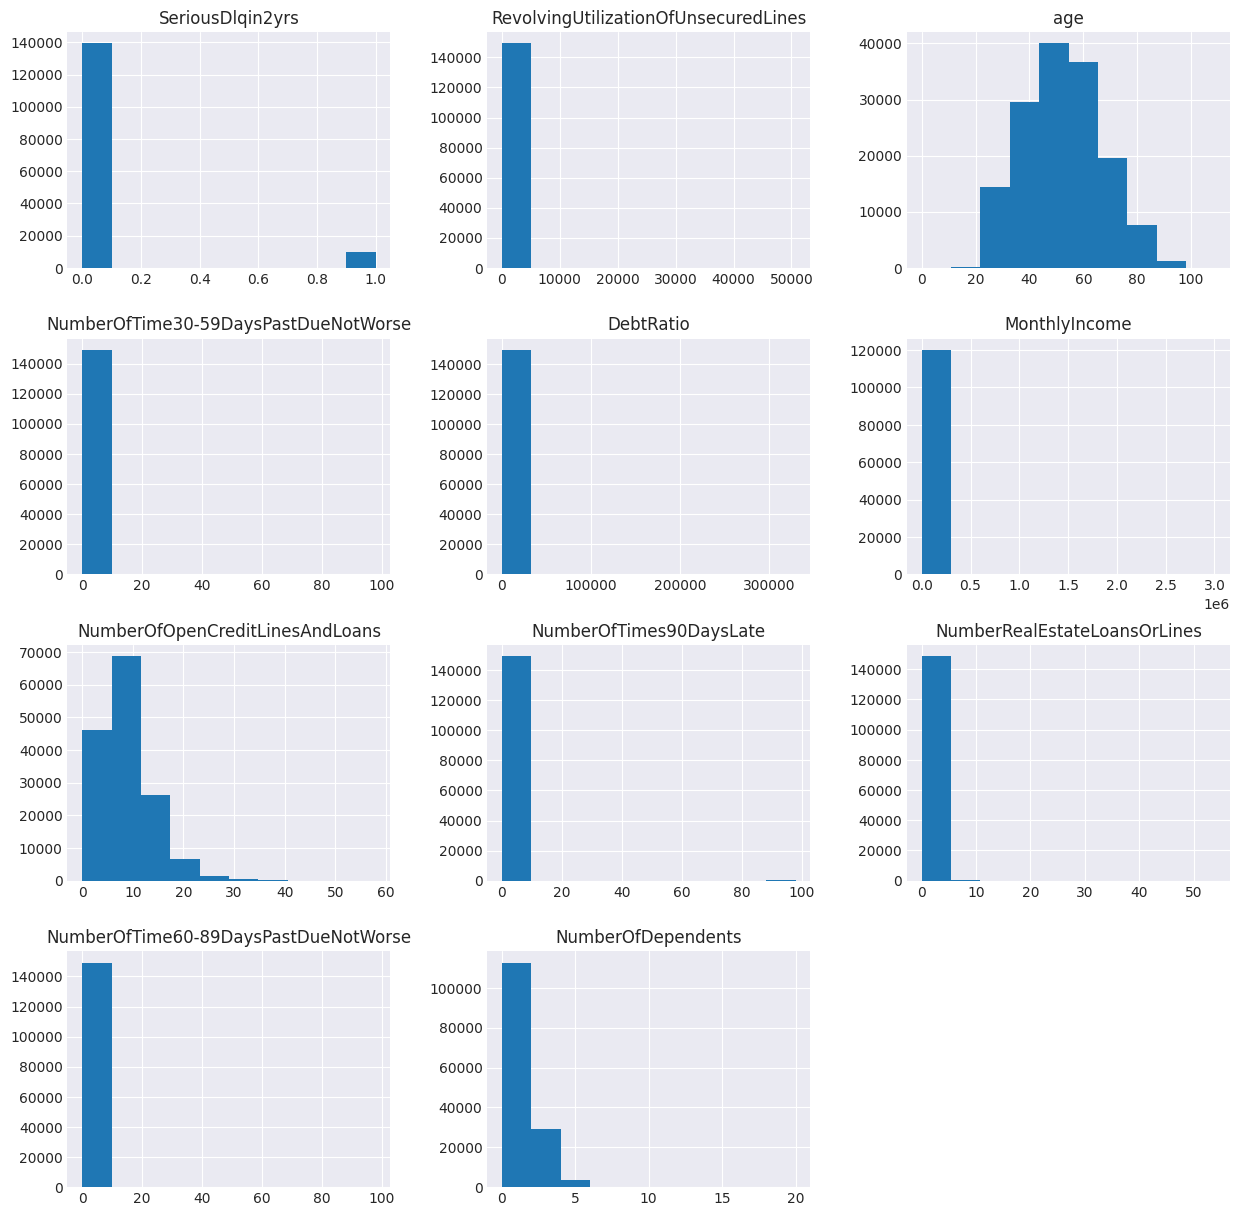

In [14]:
df.hist(figsize=(15, 15))

In [15]:
df["MonthlyIncome"].sort_values()

69263     0.0
134002    0.0
99887     0.0
107222    0.0
144170    0.0
         ... 
149977    NaN
149978    NaN
149985    NaN
149993    NaN
149998    NaN
Name: MonthlyIncome, Length: 149391, dtype: float64

In [16]:
df[(df["MonthlyIncome"]==0) & (df["SeriousDlqin2yrs"]==1)]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
4535,1,0.798359,45,0,185.0,0.0,5,0,0,1,3.0
7222,1,1.000000,29,0,494.0,0.0,2,0,0,0,0.0
8290,1,1.000000,37,1,2486.0,0.0,7,1,1,1,4.0
8506,1,0.641294,47,1,684.0,0.0,5,5,0,5,0.0
9880,1,1.000000,63,2,1031.0,0.0,7,2,2,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
144136,1,0.555997,52,1,1895.0,0.0,16,0,2,0,2.0
144679,1,1.000000,62,1,2150.0,0.0,4,0,2,0,0.0
146202,1,0.184198,35,1,977.0,0.0,4,0,1,0,2.0
148760,1,0.000000,56,0,2662.0,0.0,14,0,2,0,1.0


In [17]:
df.groupby('SeriousDlqin2yrs')["age"].count()

SeriousDlqin2yrs
0    139382
1     10009
Name: age, dtype: int64

In [18]:
df[df['RevolvingUtilizationOfUnsecuredLines'] > 100]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
294,0,2340.0,45,0,0.339333,8333.0,7,0,2,0,2.0
698,1,2066.0,58,0,0.271121,6000.0,8,1,1,0,1.0
1992,1,1143.0,44,2,0.547762,6500.0,13,0,4,0,2.0
2332,0,6324.0,59,0,0.136673,11318.0,4,0,1,0,1.0
4279,0,1982.0,33,0,0.144982,8000.0,4,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
145588,0,7452.0,52,0,0.351365,10000.0,5,0,2,0,3.0
149103,0,6109.0,43,0,0.229902,12500.0,9,0,2,0,0.0
149161,0,22000.0,38,0,1.080020,3973.0,7,0,2,0,3.0
149246,0,771.0,52,0,0.832021,8000.0,13,0,3,0,0.0


In [19]:
df[(df['RevolvingUtilizationOfUnsecuredLines'] > 100)&(df['SeriousDlqin2yrs'] == 1)]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
698,1,2066.000000,58,0,0.271121,6000.0,8,1,1,0,1.0
1992,1,1143.000000,44,2,0.547762,6500.0,13,0,4,0,2.0
7638,1,1577.000000,37,0,0.479826,5526.0,11,0,2,0,2.0
8722,1,3383.000000,31,0,0.096226,4000.0,3,0,0,0,0.0
31806,1,3629.000000,46,1,1407.000000,NaN,5,3,1,0,0.0
86434,1,250.583333,67,0,0.012748,8000.0,1,1,0,0,0.0
88556,1,3572.000000,34,0,0.988607,4300.0,10,0,2,0,1.0
114779,1,6190.000000,27,0,0.478532,1280.0,6,0,0,1,1.0
127333,1,2583.000000,70,0,0.178470,6000.0,9,0,1,0,0.0
129652,1,3818.000000,39,2,1.154265,3668.0,12,1,2,0,0.0


**Удаляем явные выбросы по RevolvingUtilizationOfUnsecuredLines (11 отрицательных меток из 223 значений).**

In [20]:
df = df.drop(df[df['RevolvingUtilizationOfUnsecuredLines']>100].index, axis=0)

In [21]:
df[(df['DebtRatio'] > 2)]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
7,0,0.305682,57,0,5710.0,NaN,8,0,3,0,0.0
9,0,0.116951,27,0,46.0,NaN,2,0,0,0,NaN
15,0,0.019657,76,0,477.0,0.0,6,0,1,0,0.0
17,0,0.061086,78,0,2058.0,NaN,10,0,2,0,0.0
33,0,0.083418,62,0,977.0,NaN,6,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149977,0,0.000627,76,0,60.0,NaN,5,0,0,0,0.0
149978,0,0.236450,29,0,349.0,NaN,3,0,0,0,0.0
149985,0,0.037548,84,0,25.0,NaN,5,0,0,0,0.0
149993,0,0.871976,50,0,4132.0,NaN,11,0,1,0,3.0


**31038 записей с DebtRatio больше 2, что как минимум странно, учитывая, что это процент и максимум тут должен быть 1, тем более, что целевая метка положительная. Скорре всего это связано с тем, что не указан MonthlyIncome.** 

In [22]:
df[(df['DebtRatio'] > 1) & (df['MonthlyIncome'] == 0)].groupby('SeriousDlqin2yrs')["age"].count().sort_values(ascending=False)

SeriousDlqin2yrs
0    1460
1      59
Name: age, dtype: int64

**Попробуем оставить DebtRatio как есть.**

<AxesSubplot: >

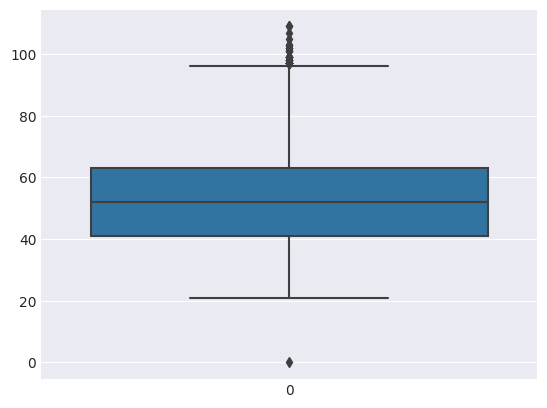

In [23]:
import seaborn as sns
sns.boxplot(data=df['age'].values, width=0.8)

**Удалим запись с явно неверным значением 0.**

In [24]:
df = df.drop(df[df['age']==0].index, axis=0)

<AxesSubplot: >

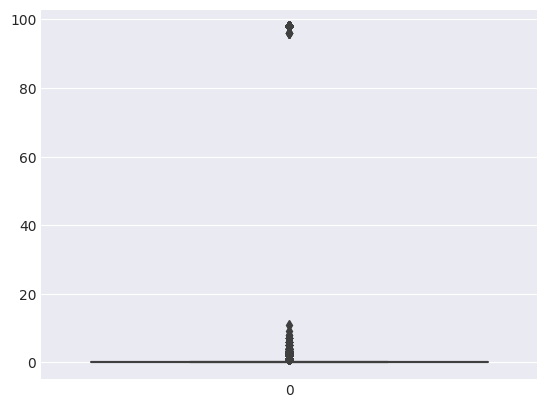

In [25]:
import seaborn as sns
sns.boxplot(data=df['NumberOfTime60-89DaysPastDueNotWorse'].values, width=0.8)

In [26]:
df[df['NumberOfTime60-89DaysPastDueNotWorse'] > 96]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1734,1,1.0,27,98,0.0,2700.0,0,98,0,98,0.0
2287,0,1.0,22,98,0.0,NaN,0,98,0,98,0.0
3885,0,1.0,38,98,12.0,NaN,0,98,0,98,0.0
4418,0,1.0,21,98,0.0,0.0,0,98,0,98,0.0
4706,0,1.0,21,98,0.0,2000.0,0,98,0,98,0.0
...,...,...,...,...,...,...,...,...,...,...,...
147259,1,1.0,25,98,0.0,NaN,0,98,0,98,NaN
147775,1,1.0,68,98,255.0,NaN,0,98,0,98,0.0
149154,1,1.0,24,98,54.0,NaN,0,98,0,98,0.0
149240,0,1.0,26,98,0.0,2000.0,0,98,0,98,0.0


**NumberOfTime60-89DaysPastDueNotWorse удалим запсиси со значениями выше 96 (220 записей).**

In [27]:
df = df.drop(df[df['NumberOfTime60-89DaysPastDueNotWorse'] > 95].index, axis=0) 

Проверьте наличие NaN, при необходимости осуществите замену

<AxesSubplot: >

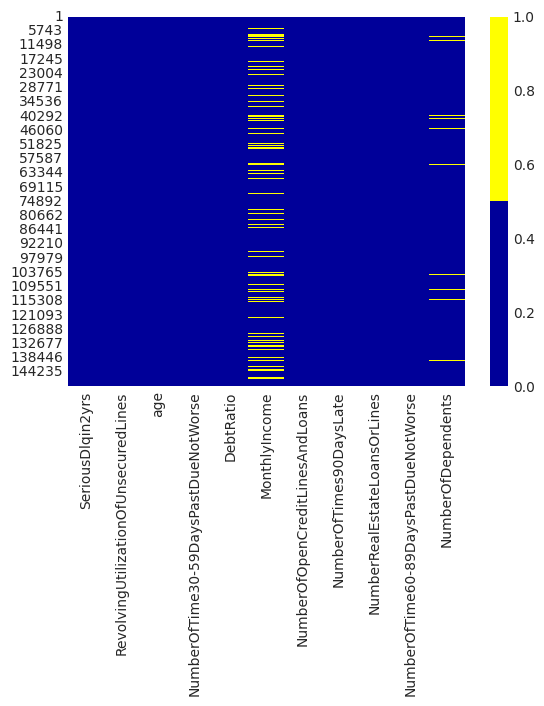

In [28]:
cols = df.columns 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [29]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

SeriousDlqin2yrs - 0%
RevolvingUtilizationOfUnsecuredLines - 0%
age - 0%
NumberOfTime30-59DaysPastDueNotWorse - 0%
DebtRatio - 0%
MonthlyIncome - 20%
NumberOfOpenCreditLinesAndLoans - 0%
NumberOfTimes90DaysLate - 0%
NumberRealEstateLoansOrLines - 0%
NumberOfTime60-89DaysPastDueNotWorse - 0%
NumberOfDependents - 3%


In [30]:
df.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29079
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3800
dtype: int64

In [31]:
df['MonthlyIncome'].quantile(0.25)

3400.0

**Заменим пустые значения MonthlyIncome на 25% значение по колонке. Записей слишком много, чтобы их удалять.**

In [32]:
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].quantile(0.25))

<Figure size 1500x300 with 0 Axes>

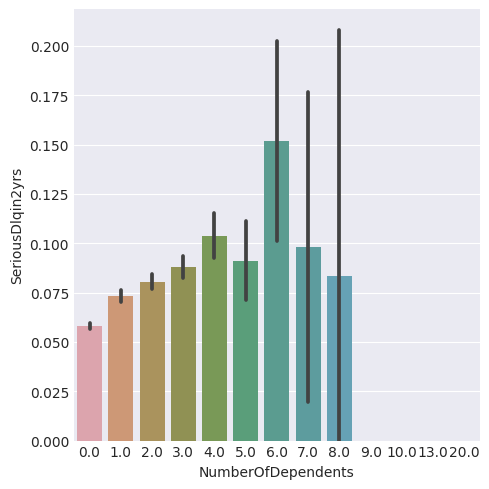

In [33]:
import seaborn as sns

plt.figure(figsize=(15,3))
sns.catplot(data = df,y='SeriousDlqin2yrs',x='NumberOfDependents',
            kind='bar', saturation=0.5)

In [34]:
df[df['NumberOfDependents'] >8]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
6300,0,0.226616,40,1,0.576539,6316.0,11,2,1,0,20.0
10619,0,0.000000,44,0,0.035590,12896.0,5,0,0,0,10.0
12983,0,0.325828,39,0,0.027100,4833.0,6,0,0,0,10.0
22699,0,0.139466,43,1,3621.000000,0.0,9,0,1,0,10.0
39096,0,0.079194,60,0,0.133582,7500.0,10,0,0,0,10.0
42167,0,0.099401,58,0,3592.000000,3400.0,14,0,1,0,9.0
44849,0,1.000000,38,0,0.643728,2789.0,5,0,1,0,9.0
122769,0,0.494849,37,0,0.268706,3300.0,9,1,0,0,9.0
123912,0,0.017858,47,1,0.368932,9166.0,7,0,1,0,10.0
128035,0,1.000000,53,1,0.230054,3333.0,3,1,1,0,13.0


**NumberOfDependents выше 8 иждевенцев - 12 записей, у всех целевая метка положительная. Скорее всего выброс - удаляем.**

In [35]:
ind_missing_child_out = df[df['NumberOfDependents'] > 8].index

In [36]:
df = df.drop(ind_missing_child_out, axis=0)

**Заменим пустые значения по NumberOfDependents на 1. Это меньше, чем медиана. Лучше для банка и кредитополучателя.**

In [37]:
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(1)

In [38]:
df.shape

(148930, 11)

In [39]:
df.isna().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

array([[<AxesSubplot: title={'center': 'SeriousDlqin2yrs'}>,
        <AxesSubplot: title={'center': 'RevolvingUtilizationOfUnsecuredLines'}>,
        <AxesSubplot: title={'center': 'age'}>],
       [<AxesSubplot: title={'center': 'NumberOfTime30-59DaysPastDueNotWorse'}>,
        <AxesSubplot: title={'center': 'DebtRatio'}>,
        <AxesSubplot: title={'center': 'MonthlyIncome'}>],
       [<AxesSubplot: title={'center': 'NumberOfOpenCreditLinesAndLoans'}>,
        <AxesSubplot: title={'center': 'NumberOfTimes90DaysLate'}>,
        <AxesSubplot: title={'center': 'NumberRealEstateLoansOrLines'}>],
       [<AxesSubplot: title={'center': 'NumberOfTime60-89DaysPastDueNotWorse'}>,
        <AxesSubplot: title={'center': 'NumberOfDependents'}>,
        <AxesSubplot: >]], dtype=object)

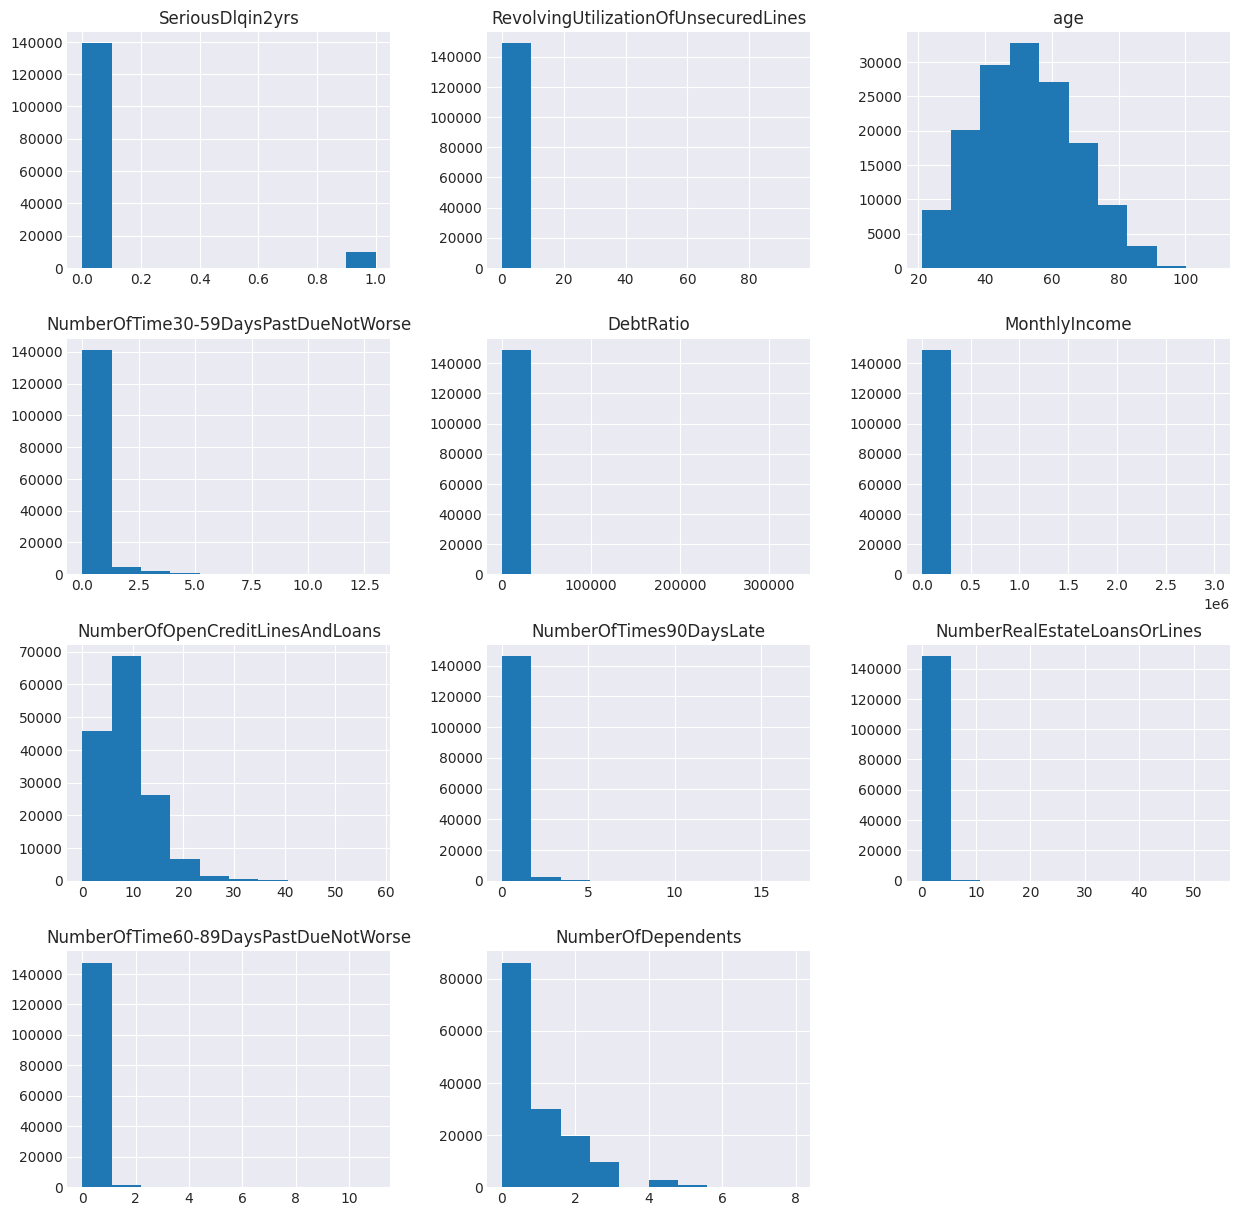

In [40]:
df.hist(figsize=(15, 15))

In [41]:
df.SeriousDlqin2yrs.value_counts()

0    139068
1      9862
Name: SeriousDlqin2yrs, dtype: int64

In [42]:
9862/139068*100

7.091494808295222

**93% кредит вернули.**

**Precision и recall не зависят, в отличие от accuracy, от соотношения классов и потому применимы в условиях несбалансированных выборок. Критерий AUC-ROC также в теории устойчив к несбалансированным классам.**

__Визуализация данных__

In [43]:
df.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [44]:
df[:100]['SeriousDlqin2yrs'].value_counts()

0    93
1     7
Name: SeriousDlqin2yrs, dtype: int64

In [45]:
# sns.pairplot(df[:100], hue='SeriousDlqin2yrs', diag_kind='hist', corner=True)

Используя sns.heatmap постройте корреляционную матрицу.

In [46]:
corr_mat = df.corr()

<AxesSubplot: >

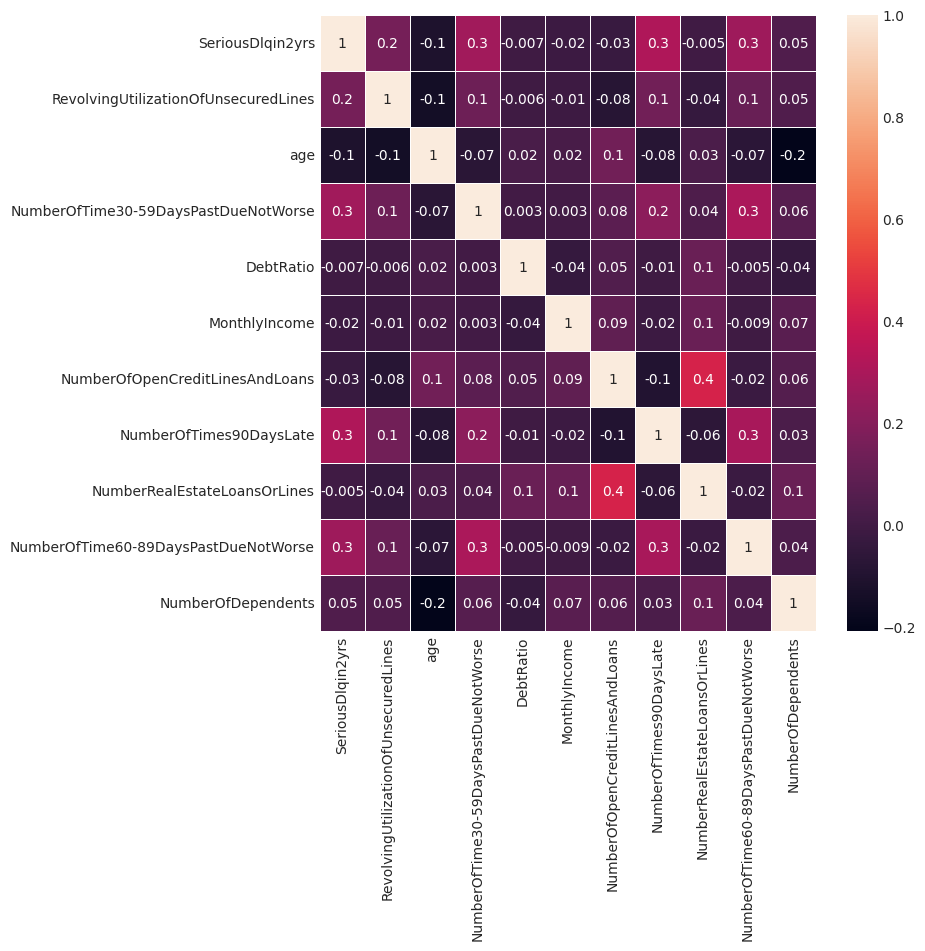

In [47]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr_mat, annot=True, linewidths=.5, fmt='.1g')

**Сильной зависимости между целевым признаком и остальными нет. Самый высокий показатель зависимости у целевого признака с просрочкой в выплате кредитов.**

# Torch

In [48]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [49]:
y = df.SeriousDlqin2yrs
X = df.drop(['SeriousDlqin2yrs'], axis=1)

In [50]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [51]:
y = le.fit_transform(y)

**Проскалируем признаки**

In [52]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

**Выделим тренировочную и тестовую выборки**

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7, 
                                                    random_state=42, 
                                                    stratify=y)

In [54]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    train_size=0.8, 
                                                    random_state=42, 
                                                    stratify=y)

In [55]:
device = torch.device("mps") 

In [56]:
class Data(Dataset):
  '''Dataset Class to store the samples and their corresponding labels, 
  and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.
  '''

  def __init__(self, X: np.ndarray, y: np.ndarray) -> None:

    # need to convert float64 to float32 else 
    # will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = torch.from_numpy(X.astype(np.float32))
    self.y = torch.from_numpy(y.astype(np.float32))
#     self.y = torch.from_numpy(y)
    self.len = self.X.shape[0]
  
  def __getitem__(self, index: int) -> tuple:
    return self.X[index], self.y[index]

  def __len__(self) -> int:
    return self.len

In [57]:
# Generate the training dataset
traindata = Data(X_train, y_train)

In [58]:
validdata = Data(X_valid, y_valid)

In [59]:
batch_size = 512

# Load the training data into data loader with the 
# respective batch_size and num_workers
train_loader = DataLoader(traindata, batch_size=batch_size, 
                         shuffle=True, num_workers=0)

In [60]:
val_loader = DataLoader(validdata, batch_size=batch_size, 
                         shuffle=True, num_workers=0)

In [61]:
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(10, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50,25)
        self.fc4 = nn.Linear(25,1)
    
    def forward(self, x):
#         x = x.view(-1, 10)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [62]:
model = SimpleNet()
model = model.to(device)

In [63]:
model

SimpleNet(
  (fc1): Linear(in_features=10, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=1, bias=True)
)

In [64]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [65]:
model.train()

SimpleNet(
  (fc1): Linear(in_features=10, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=1, bias=True)
)

In [66]:
# Функция вычисления метрики Accuracy бинарной классификации
def binary_acc(y_pred, y_true):
    y_pred_val = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = torch.eq(y_pred_val, y_true).sum().float()
    acc = correct_results_sum/y_true.shape[0]

    #acc = torch.round(acc * 100)   
    return acc

In [67]:
def train(model, optimizer, loss_fn, train_loader, val_loader, device, epochs=20):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            targets = targets.unsqueeze(-1)
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            targets = targets.unsqueeze(-1)
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            acc = binary_acc(output, targets)
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, acc))

In [68]:
train(model, optimizer, torch.nn.BCEWithLogitsLoss(), train_loader, val_loader, epochs=5, device=device)

Epoch: 1, Training Loss: 0.20, Validation Loss: 0.18, accuracy = 0.94
Epoch: 2, Training Loss: 0.19, Validation Loss: 0.18, accuracy = 0.91
Epoch: 3, Training Loss: 0.19, Validation Loss: 0.18, accuracy = 0.92
Epoch: 4, Training Loss: 0.19, Validation Loss: 0.18, accuracy = 0.89
Epoch: 5, Training Loss: 0.19, Validation Loss: 0.18, accuracy = 0.97


In [69]:
testdata = Data(X_test, y_test)
test_loader = DataLoader(testdata, batch_size=batch_size, 
                        shuffle=True, num_workers=0)

In [70]:
# y_pred_list = []
# outputs = []
# model.eval()
# with torch.no_grad():
#     for batch in test_loader:
#         inputs, targets = batch
# #         targets = targets.unsqueeze(-1)
#         inputs = inputs.to(device)
#         output = model(inputs)
#         print(len(output))
#         output_tag = torch.round(torch.sigmoid(output))
#         outputs.append(output_tag)
#         print(len(outputs))
# #         print(output_tag) 
# #         correct_results_sum = torch.eq(y_pred_val, y_true).sum().float()
# #         acc = correct_results_sum/y_true.shape[0]
#         y_pred_list.append(output_tag)
# #         print(len(y_pred_list))

# # y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [71]:
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_pred_list)

---

In [72]:
import time

In [78]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(10, 100)
        self.l2 = nn.Linear(100, 50)
        self.l3 = nn.Linear(50, 25)
        self.l4 = nn.Linear(25, 1)

    def forward(self, x):
#         x = x.view(-1, 784)  # Flatten the data (n, 1, 28, 28)-> (n, 784)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        return self.l4(x)


model = Net()
device = torch.device("mps") 
model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.unsqueeze(-1)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} | Batch Status: {}/{} ({:.0f}%) | Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in train_loader:
        target = target.unsqueeze(-1)
        data, target = data.to(device), target.to(device)
        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(train_loader.dataset)
    print(f'===========================\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(train_loader.dataset)} '
          f'({100. * correct / len(train_loader.dataset):.0f}%)')


if __name__ == '__main__':
    since = time.time()
    for epoch in range(1, 5):
        epoch_start = time.time()
        train(epoch)
        m, s = divmod(time.time() - epoch_start, 60)
        print(f'Training time: {m:.0f}m {s:.0f}s')
        test()
        m, s = divmod(time.time() - epoch_start, 60)
        print(f'Testing time: {m:.0f}m {s:.0f}s')

    m, s = divmod(time.time() - since, 60)
    print(f'Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {device}!')

Train Epoch: 1 | Batch Status: 0/119144 (0%) | Loss: 0.641136
Train Epoch: 1 | Batch Status: 5120/119144 (4%) | Loss: 0.599154
Train Epoch: 1 | Batch Status: 10240/119144 (9%) | Loss: 0.567217
Train Epoch: 1 | Batch Status: 15360/119144 (13%) | Loss: 0.528922
Train Epoch: 1 | Batch Status: 20480/119144 (17%) | Loss: 0.506071
Train Epoch: 1 | Batch Status: 25600/119144 (21%) | Loss: 0.476316
Train Epoch: 1 | Batch Status: 30720/119144 (26%) | Loss: 0.458658
Train Epoch: 1 | Batch Status: 35840/119144 (30%) | Loss: 0.410827
Train Epoch: 1 | Batch Status: 40960/119144 (34%) | Loss: 0.418168
Train Epoch: 1 | Batch Status: 46080/119144 (39%) | Loss: 0.375107
Train Epoch: 1 | Batch Status: 51200/119144 (43%) | Loss: 0.395425
Train Epoch: 1 | Batch Status: 56320/119144 (47%) | Loss: 0.347006
Train Epoch: 1 | Batch Status: 61440/119144 (52%) | Loss: 0.329465
Train Epoch: 1 | Batch Status: 66560/119144 (56%) | Loss: 0.335392
Train Epoch: 1 | Batch Status: 71680/119144 (60%) | Loss: 0.353703
Tra

---

**Ниже решениее с помощью tf RNN для сравнения.**

# **Нейронные сети**

In [204]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import utils
from tensorflow.keras.metrics import AUC
import numpy as np
import matplotlib.pyplot as plt
#from scipy.misc.pilutil import toimage
%matplotlib inline 

In [205]:
from sklearn.model_selection import train_test_split

y = df.SeriousDlqin2yrs
X = df.drop(['SeriousDlqin2yrs'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7, 
                                                    random_state=42, 
                                                    stratify=y)

In [206]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(X_train)
test_X_scaled = scaler.fit_transform(X_test)

In [207]:
model = Sequential()

**Добавляем уровни сети.**

In [208]:
model.add(Dense(100, input_dim=10, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(25, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

**Компилируем сеть.**

In [209]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", AUC()])

In [210]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 100)               1100      
_________________________________________________________________
dense_17 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_18 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 26        
Total params: 7,451
Trainable params: 7,451
Non-trainable params: 0
_________________________________________________________________


**Обучаем нейронную сеть.**

In [211]:
%%time

history = model.fit(train_X_scaled, y_train, batch_size=512, epochs=5, validation_split=0.2)

Epoch 1/5
  1/163 [..............................] - ETA: 1:33 - loss: 0.6581 - accuracy: 0.8809 - auc_3: 0.2905

2023-03-21 15:19:00.838194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - ETA: 0s - loss: 0.2372 - accuracy: 0.9349 - auc_3: 0.6145

2023-03-21 15:19:02.761931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - 3s 14ms/step - loss: 0.2372 - accuracy: 0.9349 - auc_3: 0.6145 - val_loss: 0.1890 - val_accuracy: 0.9370 - val_auc_3: 0.7696
Epoch 2/5
163/163 [==============================] - 2s 11ms/step - loss: 0.1833 - accuracy: 0.9363 - auc_3: 0.7953 - val_loss: 0.1839 - val_accuracy: 0.9373 - val_auc_3: 0.8112
Epoch 3/5
163/163 [==============================] - 2s 11ms/step - loss: 0.1800 - accuracy: 0.9371 - auc_3: 0.8199 - val_loss: 0.1823 - val_accuracy: 0.9376 - val_auc_3: 0.8266
Epoch 4/5
163/163 [==============================] - 2s 11ms/step - loss: 0.1788 - accuracy: 0.9367 - auc_3: 0.8311 - val_loss: 0.1821 - val_accuracy: 0.9375 - val_auc_3: 0.8347
Epoch 5/5
163/163 [==============================] - 2s 11ms/step - loss: 0.1782 - accuracy: 0.9371 - auc_3: 0.8373 - val_loss: 0.1830 - val_accuracy: 0.9372 - val_auc_3: 0.8397
CPU times: user 9.98 s, sys: 5.52 s, total: 15.5 s
Wall time: 9.98 s


**Оцениваем качество работы сети.**

In [212]:
scores = model.evaluate(test_X_scaled, y_test, verbose=0)

print("Точность работы на тестовых данных: %.2f%%" % (scores[1]*100))
print("AUC на тестовых данных: %.2f%%" % (scores[2]*100))

Точность работы на тестовых данных: 93.81%
AUC на тестовых данных: 84.03%


**Графики качества во время обучения.**

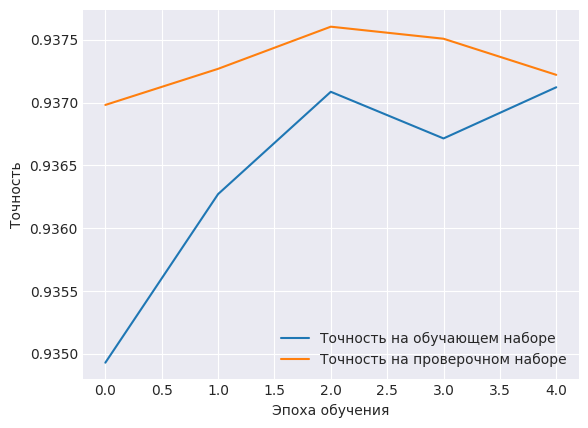

In [215]:
plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()